In [46]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: []


In [47]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
dataset_path = "/content/drive/MyDrive/Dataset"

In [49]:
for cls in ["low", "medium", "high"]:
    flatten_folder_safe(f"dataset/{cls}")

In [50]:
import os

print("Contents of Dataset folder:")
print(os.listdir(dataset_path))

Contents of Dataset folder:
['low', 'medium', 'high']


In [51]:
for old, new in [("High", "high"), ("Medium", "medium"), ("Low", "low")]:
    old_path = os.path.join(dataset_path, old)
    new_path = os.path.join(dataset_path, new)
    if os.path.exists(old_path):
        os.rename(old_path, new_path)

In [52]:
for cls in ["low", "medium", "high"]:
    path = os.path.join(dataset_path, cls)
    print(cls, ":", len(os.listdir(path)), "files")

low : 54 files
medium : 95 files
high : 130 files


In [53]:
!pip install -q tensorflow scikit-learn

In [54]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

In [55]:
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS_BASE = 12      # baseline
EPOCHS_FINE = 12      # fine-tuning
NUM_CLASSES = 3

In [56]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    zoom_range=0.1,
    horizontal_flip=True
)

In [57]:
train_data = datagen.flow_from_directory(
    dataset_path,                 # ✅ FIXED
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    subset="training",
    shuffle=True
)

val_data = datagen.flow_from_directory(
    dataset_path,                 # ✅ FIXED
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    subset="validation",
    shuffle=False
)


Found 224 images belonging to 3 classes.
Found 55 images belonging to 3 classes.


In [58]:
labels = train_data.classes
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.717948717948718), 1: np.float64(1.696969696969697), 2: np.float64(0.9824561403508771)}


In [61]:
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # baseline

In [62]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation="relu"),   # 🔴 smaller
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

In [63]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",  # ✅ FIX
    metrics=["accuracy"]
)


In [64]:
history_base = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS_BASE,
    class_weight=class_weights
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
14/14 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - accuracy: 0.3431 - loss: 1.1312 - val_accuracy: 0.1818 - val_loss: 1.1032
Epoch 2/12
14/14 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step - accuracy: 0.3816 - loss: 1.1145 - val_accuracy: 0.3455 - val_loss: 1.0951
Epoch 3/12
14/14 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.3564 - loss: 1.1202 - val_accuracy: 0.3455 - val_loss: 1.1030
Epoch 4/12
14/14 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.2893 - loss: 1.1510 - val_accuracy: 0.1818 - val_loss: 1.1109
Epoch 5/12
14/14 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.2942 - loss: 1.1471 - val_accuracy: 0.4727 - val_loss: 1.0970
Epoch 6/12
14/14 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.2896 - loss: 1.1393 - val_accuracy: 0.4727 - val_loss: 1.0894
Epoch 7/12
14/14 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.4167 - loss: 1.0870 - val_accuracy: 0.3455 - val_loss: 1.0862
Epoch 8/12
14/14 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.3541 - loss: 1.1039 - val_accuracy: 0.3455 - val_loss:

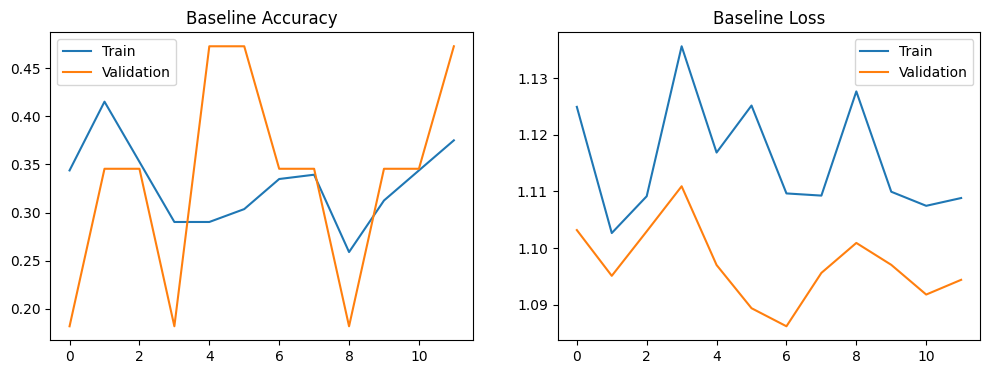

In [65]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_base.history["accuracy"], label="Train")
plt.plot(history_base.history["val_accuracy"], label="Validation")
plt.title("Baseline Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_base.history["loss"], label="Train")
plt.plot(history_base.history["val_loss"], label="Validation")
plt.title("Baseline Loss")
plt.legend()

plt.show()

In [66]:
base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

In [67]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [68]:
history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weights
)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.2715 - loss: 1.1827 - val_accuracy: 0.1818 - val_loss: 1.1083
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.2093 - loss: 1.1336 - val_accuracy: 0.1818 - val_loss: 1.1194
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.2659 - loss: 1.1388 - val_accuracy: 0.1818 - val_loss: 1.1308
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.2267 - loss: 1.1447 - val_accuracy: 0.1818 - val_loss: 1.1412
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.2947 - loss: 1.1384 - val_accuracy: 0.1818 - val_loss: 1.1493
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.3269 - loss: 1.1009 - val_accuracy: 0.1818 - val_loss: 1.1558
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.2451 - loss: 1.0885 - val_accuracy: 0.1818 - val_loss: 1.1620
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.3475 - loss: 1.1349 - val_accuracy: 0.1818 - val_loss:

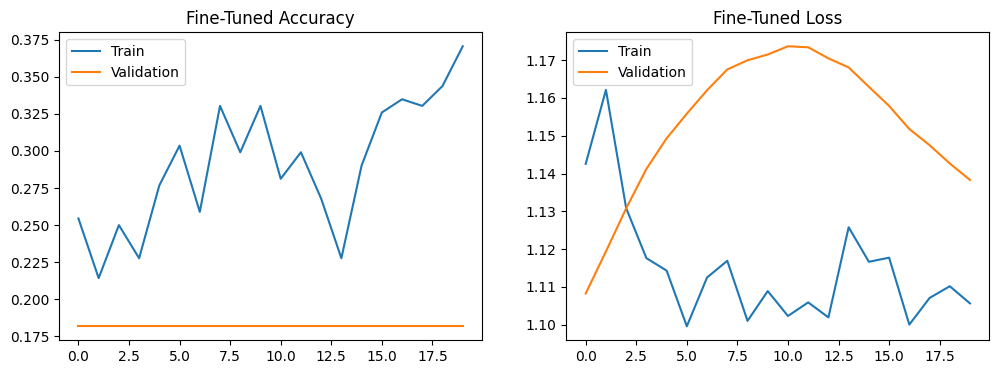

In [69]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_fine.history["accuracy"], label="Train")
plt.plot(history_fine.history["val_accuracy"], label="Validation")
plt.title("Fine-Tuned Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_fine.history["loss"], label="Train")
plt.plot(history_fine.history["val_loss"], label="Validation")
plt.title("Fine-Tuned Loss")
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step


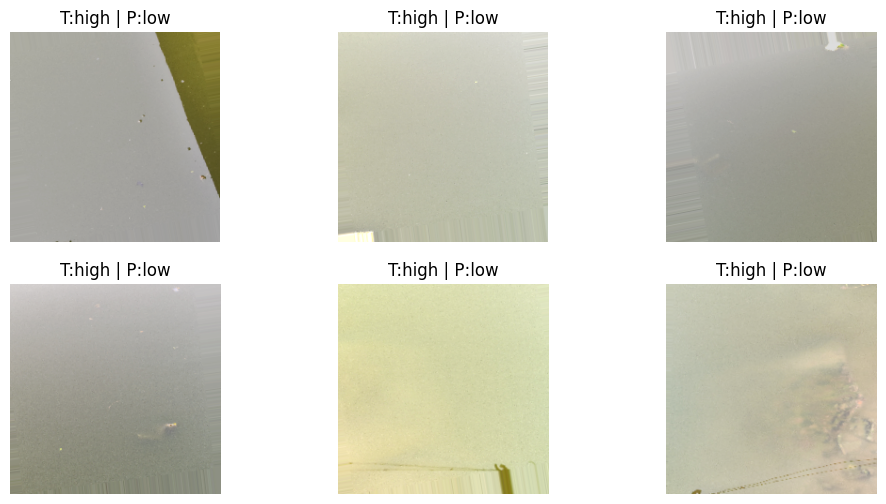

In [74]:
import matplotlib.pyplot as plt

class_names = list(val_data.class_indices.keys())

images, labels = next(val_data)
preds = model.predict(images)

plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    true_label = class_names[np.argmax(labels[i])]
    pred_label = class_names[np.argmax(preds[i])]
    plt.title(f"T:{true_label} | P:{pred_label}")
    plt.axis("off")

plt.show()

In [75]:
from sklearn.metrics import classification_report, confusion_matrix

val_preds = model.predict(val_data)
y_pred = val_preds.argmax(axis=1)
y_true = val_data.classes

print("Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(val_data.class_indices.keys())
))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step
Classification Report:
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        26
         low       0.18      1.00      0.31        10
      medium       0.00      0.00      0.00        19

    accuracy                           0.18        55
   macro avg       0.06      0.33      0.10        55
weighted avg       0.03      0.18      0.06        55

Confusion Matrix:
[[ 0 26  0]
 [ 0 10  0]
 [ 0 19  0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


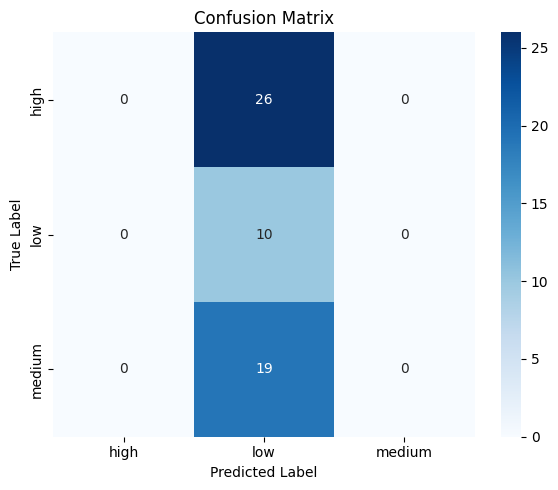

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names = ["high", "low", "medium"]

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [76]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,998,030 (26.70 MB)

 Trainable params: 1,433,139 (5.47 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

 Optimizer params: 2,866,280 (10.93 MB)